In [3]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint 
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import warnings
from scipy.stats import ttest_ind
warnings.filterwarnings('ignore')

In [4]:
choice_order = ["gt", "mid", "lp"]
# Define fixed color palettes
# time_limit_palette = {'1000.0': "#d6604d", '3000.0': "#f4a582"} 
time_limit_palette = {'700.0': "#d6604d", '3000.0': "#f4a582"} 
choice_palette = {"gt": "#b2df8a", "mid": "#1f78b4", "lp": "#a6cee3"}  
response_palette = {"f": "#e08214", "j": "#8073ac"}

## Process Single Participant Data

In [6]:
def process_file(filename, canvas_width=1000):
    print(filename)
    # Add participant ID
    participant_ID = os.path.splitext(os.path.basename(filename))[0]
    df = pd.read_csv(filename)
    df['participant_ID'] = participant_ID

    # Select relevant columns
    selected_columns = [
        'subject_id', 'study_id', 'session_id', 'participant_ID', 
        'rt', 'response', 'task', 'ball_X', 'obstacle_groundTruth_x',
        'obstacle_groundTruth_y', 'stimulus_idx', 'trial_name', 'flipped',
        'choice', 'timeLimit', 'obstacle_choice_x', 'obstacle_choice_y', 'currentTrial'
    ]
    df = df[selected_columns]

    # Filter rows for specific tasks
    df = df[df['task'].isin(['ballFalling', 'yesOrNo'])]

    # Merge rows for 'ballFalling' and 'yesOrNo' tasks
    merged_df = df.groupby(['participant_ID', 'currentTrial'], as_index=False).first()

    # Sanity check
    print('----------Sanity Check---------')
    if merged_df.shape[0] != 144:
        print(f"For {participant_ID}, total rows: {merged_df.shape[0]}")
    if merged_df['stimulus_idx'].nunique() != 12 or merged_df['choice'].nunique() != 3 or len(merged_df['timeLimit'].unique()) != 2:
        print(f"ERROR IN DATA: {participant_ID}")
        print(f"Unique stimulus_idx: {merged_df['stimulus_idx'].nunique()}, choice: {merged_df['choice'].nunique()}, time limit: {merged_df['timeLimit'].unique()}")
    grouped = merged_df.groupby(['stimulus_idx', 'choice', 'timeLimit'])
    if not all(len(group) == 2 for _, group in grouped):
        print(f":( ERROR IN DATA GROUPING: {participant_ID}")
    else:
        print('---------CLEAR :)---------')

    # Adjust flipped data
    merged_df['ball_X_final'] = merged_df['ball_X']
    merged_df['obstacle_groundTruth_x_final'] = merged_df['obstacle_groundTruth_x']
    merged_df['obstacle_choice_x_final'] = merged_df['obstacle_choice_x']

    merged_df.loc[merged_df['flipped'] == True, 'ball_X_final'] = canvas_width - merged_df['ball_X']
    merged_df.loc[merged_df['flipped'] == True, 'obstacle_groundTruth_x_final'] = canvas_width - merged_df['obstacle_groundTruth_x']
    merged_df.loc[merged_df['flipped'] == True, 'obstacle_choice_x_final'] = canvas_width - merged_df['obstacle_choice_x']

    # Handling missing data
    # Replace 'None' with NaN for missing data
    # merged_df
    merged_df['response'] = merged_df['response'].replace('None', pd.NA)
    merged_df['rt'] = merged_df['rt'].replace('None', pd.NA)

    # Accuracy calculation with explicit handling of null responses
    merged_df['is_accurate'] = merged_df.apply(
        lambda row: (
            ((row['response'] == 'j') and (row['choice'] == 'gt')) or
            ((row['response'] == 'f') and (row['choice'] in ['lp', 'mid']))
        ) if pd.notna(row['response']) else pd.NA,
        axis=1
    )

    # Explicitly cast to nullable boolean type
    merged_df['is_accurate'] = merged_df['is_accurate'].astype('boolean')

    # Enforce consistent order for 'choice'
    df['choice'] = pd.Categorical(df['choice'], categories=choice_order, ordered=True)
    return merged_df

# Example usage:
directory = 'rawData_v2/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
print(f'Number of participants: {len(files)}.')

Number of participants: 20.


In [7]:
# print(files[-2])
# processed_data = process_file(files[-2])
# processed_data
# processed_data.groupby('timeLimit')['response'].value_counts() # good
# # number of j and f
# # Count the number of 'j' in the 'response' column
# j_count = processed_data['response'].value_counts().get('j', 0)
# f_count = processed_data['response'].value_counts().get('f', 0)
# print(j_count, f_count) # good

## Single Participant Data Summary

In [8]:
def analyze_data(df):
    # Calculate missing rate
    missing_rate_overall = df['response'].isna().mean()
    missing_rate_by_timeLimit = df.groupby('timeLimit')['response'].apply(lambda x: x.isna().mean())
    missing_rate_by_choice = df.groupby('choice')['response'].apply(lambda x: x.isna().mean())
    
    # RT analysis
    rt_overall = df['rt'].mean()
    rt_by_timeLimit = df.groupby('timeLimit')['rt'].mean()
    rt_by_choice = df.groupby('choice')['rt'].mean()

    # Split data by timeLimit
    # rt_group_1 = df[df['timeLimit'] == 1000]['rt'].dropna()
    rt_group_1 = df[df['timeLimit'] == 700]['rt'].dropna()
    rt_group_2 = df[df['timeLimit'] == 3000]['rt'].dropna()

    # Perform independent t-test
    t_stat, p_value = ttest_ind(rt_group_1, rt_group_2, equal_var=False)  # Use Welch's t-test

    print(f"T-Test Results:")
    print(f"T-Statistic: {t_stat:.3f}, P-Value: {p_value:.3e}")
    if p_value < 0.05:
        print("Result: The difference in RTs between time limits is statistically significant.")
    else:
        print("Result: The difference in RTs between time limits is not statistically significant.")

    accuracy_overall = df['is_accurate'].mean()
    accuracy_by_timeLimit = df.groupby('timeLimit')['is_accurate'].mean()
    accuracy_by_choice = df.groupby('choice')['is_accurate'].mean()

    # Average RT for accurate/inaccurate responses
    avg_rt_accurate = df[df['is_accurate']]['rt'].mean()
    avg_rt_inaccurate = df[~df['is_accurate']]['rt'].mean()

    # Results summary
    summary = {
        'Missing Rate': {
            'Overall': missing_rate_overall,
            'By TimeLimit': missing_rate_by_timeLimit.to_dict(),
            'By Choice': missing_rate_by_choice.to_dict(),
        },
        'RT': {
            'Overall': rt_overall,
            'By TimeLimit': rt_by_timeLimit.to_dict(),
            'By Choice': rt_by_choice.to_dict(),
        },
        'Accuracy': {
            'Overall': accuracy_overall,
            'By TimeLimit': accuracy_by_timeLimit.to_dict(),
            'By Choice': accuracy_by_choice.to_dict()
        },
        'Average RT for Accuracy': {
            'Accurate': avg_rt_accurate,
            'Inaccurate': avg_rt_inaccurate,
        }
    }

    # Print the summary in a readable format
    print("\nAnalysis Summary:")
    pprint(summary, width=100, sort_dicts=False)
    
    # Visualizations
    plot_data(df)
    
    return summary

def get_confusionMatrix(df):
    # Remove rows with null responses
    df = df.dropna(subset=['response'])

    # Define actual labels (positive for 'gt', negative for 'lp' or 'mid')
    df['actual'] = df['choice'].apply(lambda x: 'positive' if x == 'gt' else 'negative')

    # Define predicted labels (positive for 'j', negative for 'f')
    df['predicted'] = df['response'].apply(lambda x: 'positive' if x == 'j' else 'negative')

    # Generate confusion matrix
    cm = confusion_matrix(df['actual'], df['predicted'], labels=['positive', 'negative'])

    # Display confusion matrix
    cmd = ConfusionMatrixDisplay(cm, display_labels=['Positive', 'Negative'])
    cmd.plot(cmap='Blues')
    cmd.ax_.set_title("Confusion Matrix")
    cmd.ax_.set_xlabel("Participant Responses")
    cmd.ax_.set_ylabel("Actual Labels")

    # Disable grid lines
    cmd.ax_.grid(False)
    
    plt.show()

    # cm by time limit and choice
    for time_limit in df['timeLimit'].unique():
        subset = df[df['timeLimit'] == time_limit]
        cm_by_tl = confusion_matrix(subset['actual'], subset['predicted'], labels=['positive', 'negative'])
        print(f"Confusion Matrix for timeLimit = {time_limit}")
        print(cm_by_tl)
    
    for choice in df['choice'].unique():
        subset = df[df['choice'] == choice]
        cm_by_choice = confusion_matrix(subset['actual'], subset['predicted'], labels=['positive', 'negative'])
        print(f"Confusion Matrix for timeLimit = {choice}")
        print(cm_by_choice)
    return cm

# Functions to calculate metrics
def calculate_metrics(cm):
    # Confusion matrix values
    tn, fp, fn, tp = cm.ravel()
    accuracy = (tp + tn) / (tp + tn + fp + fn)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1_score,
        'True Positives': tp,
        'True Negatives': tn,
        'False Positives': fp,
        'False Negatives': fn
    }

def plot_data(df):
    """
    Generate visualizations for missing rate, RT, and accuracy with improved aesthetics.
    Group related plots into subplots.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Prepare data
    missing_rate_by_timeLimit = df.groupby('timeLimit')['response'].apply(lambda x: x.isna().mean()).reset_index()
    missing_rate_by_choice = df.groupby('choice')['response'].apply(lambda x: x.isna().mean()).reset_index()
    accuracy_by_timeLimit = df.groupby('timeLimit')['is_accurate'].mean().reset_index()
    accuracy_by_choice = df.groupby('choice')['is_accurate'].mean().reset_index()
    
    # Initialize the figure
    fig, axs = plt.subplots(3, 2, figsize=(8, 10), constrained_layout=True)
    fig.suptitle("Data Analysis Summary", fontsize=20, y=1.02)

    # Plot Missing Rate
    sns.barplot(data=missing_rate_by_timeLimit, x='timeLimit', y='response', ax=axs[0, 0], palette=time_limit_palette, width=0.6)
    axs[0, 0].set_title('Missing Rate by TimeLimit')
    axs[0, 0].set_xlabel('Time Limit')
    axs[0, 0].set_ylabel('Missing Rate')
    axs[0, 0].set_ylim(0, 1)

    sns.barplot(data=missing_rate_by_choice, x='choice', y='response', ax=axs[0, 1], palette=choice_palette, order=choice_order, width=0.6)
    axs[0, 1].set_title('Missing Rate by Probe Type')
    axs[0, 1].set_xlabel('Probe Type')
    axs[0, 1].set_ylabel('Missing Rate')
    axs[0, 1].set_ylim(0, 1)

    # Plot Reaction Times with Violin Plot
    sns.violinplot(data=df, x='timeLimit', y='rt', ax=axs[1, 0], palette=time_limit_palette, inner='box', scale='width')
    axs[1, 0].set_title('Reaction Time (RT) by TimeLimit')
    axs[1, 0].set_xlabel('Time Limit')
    axs[1, 0].set_ylabel('RT')

    for violin in axs[1, 0].collections:
        violin.set_edgecolor(None)

    sns.violinplot(data=df, x='choice', y='rt', ax=axs[1, 1], palette=choice_palette, order=choice_order, inner='box', scale='width')
    axs[1, 1].set_title('Reaction Time (RT) by Probe Type')
    axs[1, 1].set_xlabel('Probe Type')
    axs[1, 1].set_ylabel('RT')

    for violin in axs[1, 1].collections:
        violin.set_edgecolor(None)

    # Plot Accuracy
    sns.barplot(data=accuracy_by_timeLimit, x='timeLimit', y='is_accurate', ax=axs[2, 0], palette=time_limit_palette, width=0.6)
    axs[2, 0].set_title('Accuracy by TimeLimit')
    axs[2, 0].set_xlabel('Time Limit')
    axs[2, 0].set_ylabel('Accuracy')
    axs[2, 0].set_ylim(0, 1)

    sns.barplot(data=accuracy_by_choice, x='choice', y='is_accurate', ax=axs[2, 1], palette=choice_palette, order=choice_order, width=0.6)
    axs[2, 1].axhline(y=0.5, linewidth=2, color='black', ls=':')
    axs[2, 1].set_title('Accuracy by Probe Type')
    axs[2, 1].set_xlabel('Probe Type')
    axs[2, 1].set_ylabel('Accuracy')
    axs[2, 1].set_ylim(0, 1)

    # Show the plot
    plt.show()

In [9]:
# Create the stacked count plot
def plot_stacked_freq(data):
    sns.set_theme(style="whitegrid", context="talk")  # Set a scientific theme for aesthetics

    data = data.dropna(subset=['response'])
    # Enforce consistent order for 'choice'
    data['choice'] = pd.Categorical(data['choice'], categories=choice_order, ordered=True)

    # Create subplots for each time limit
    time_limits = data['timeLimit'].unique()
    fig, axs = plt.subplots(1, len(time_limits), figsize=(9, 6), sharey=True, constrained_layout=True)

    for i, time_limit in enumerate(sorted(time_limits)):
        ax = axs[i] if len(time_limits) > 1 else axs  # Handle single subplot case
        subset = data[data['timeLimit'] == time_limit]

        # If ploting percentage instead of counts
        # Calculate percentages
        subset['weight'] = subset.groupby('choice')['response'].transform('count')  # Total counts per choice
        subset['weight'] = 100 / subset['weight']  # Normalize to percentages
        
        # Plot a stacked bar chart
        sns.histplot(
            data=subset,
            x="choice",
            hue="response",
            weights="weight", # Use the normalized percentages
            multiple="stack",
            shrink=0.8,
            ax=ax,
            palette=response_palette,
            hue_order=['f', 'j']  # Ensure consistent hue order
        )
        ax.set_title(f"Time Limit: {time_limit}")
        ax.set_xlabel("Choice")
        # ax.set_ylabel("Count" if i == 0 else "")
        ax.axhline(y=50, linewidth=3, color="black", ls=':')
        ax.set_ylabel("Percentage" if i == 0 else "")
        ax.set_ylim(0, 110)  # Set y-axis to 0-100 for percentages

    # Add a global title
    # plt.suptitle("Stacked Count of Responses ('f' and 'j') by Time Limit and Choice", fontsize=16)
    plt.suptitle("Stacked Percentage of Responses ('f' and 'j') by Time Limit and Choice", fontsize=16)
    plt.show()

rawData_v2/663a77b9f973602bcedaf526_result.csv
----------Sanity Check---------
---------CLEAR :)---------
----------Data Quality Check---------
T-Test Results:
T-Statistic: -8.605, P-Value: 7.769e-13
Result: The difference in RTs between time limits is statistically significant.

Analysis Summary:
{'Missing Rate': {'Overall': 0.09722222222222222,
                  'By TimeLimit': {700.0: 0.19444444444444445, 3000.0: 0.0},
                  'By Choice': {'gt': 0.041666666666666664, 'lp': 0.1875, 'mid': 0.0625}},
 'RT': {'Overall': 825.876923076923,
        'By TimeLimit': {700.0: 538.0, 3000.0: 1057.7777777777778},
        'By Choice': {'gt': 768.195652173913, 'lp': 880.5384615384615, 'mid': 837.4666666666667}},
 'Accuracy': {'Overall': 0.46923076923076923,
              'By TimeLimit': {700.0: 0.4827586206896552, 3000.0: 0.4583333333333333},
              'By Choice': {'gt': 0.782608695652174,
                            'lp': 0.20512820512820512,
                            'mid': 0.3

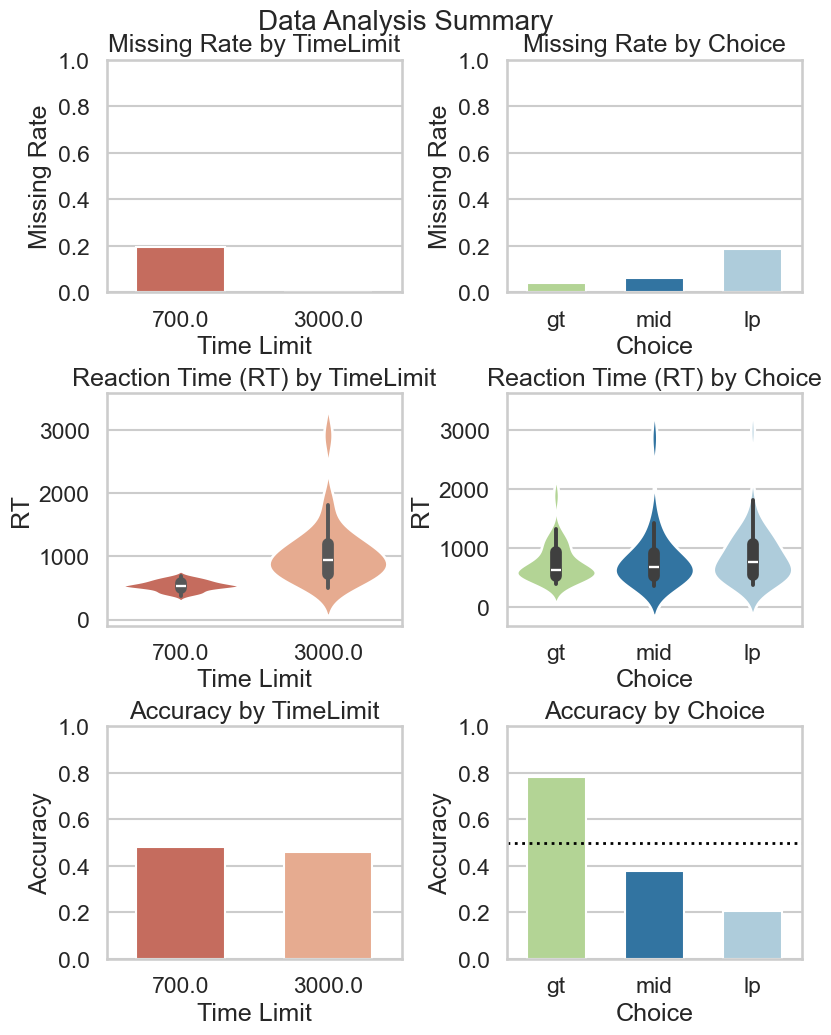

---------CLEAR---------


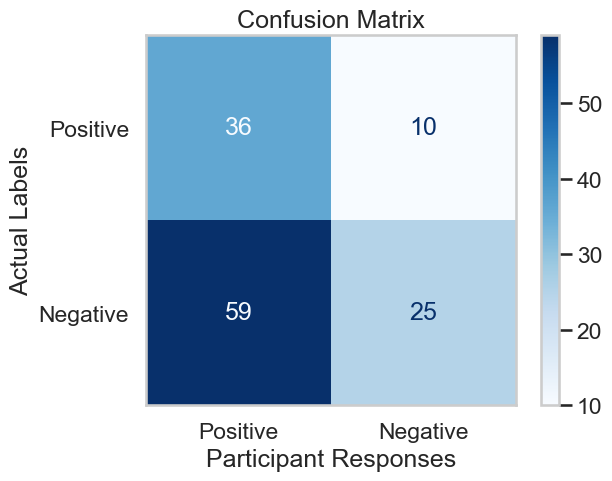

Confusion Matrix for timeLimit = 3000.0
[[20  4]
 [35 13]]
Confusion Matrix for timeLimit = 700.0
[[16  6]
 [24 12]]
Confusion Matrix for timeLimit = gt
[[36 10]
 [ 0  0]]
Confusion Matrix for timeLimit = lp
[[ 0  0]
 [31  8]]
Confusion Matrix for timeLimit = mid
[[ 0  0]
 [28 17]]
{'Accuracy': 0.46923076923076923,
 'F1 Score': 0.4201680672268908,
 'False Negatives': 59,
 'False Positives': 10,
 'Precision': 0.7142857142857143,
 'Recall': 0.2976190476190476,
 'True Negatives': 36,
 'True Positives': 25}


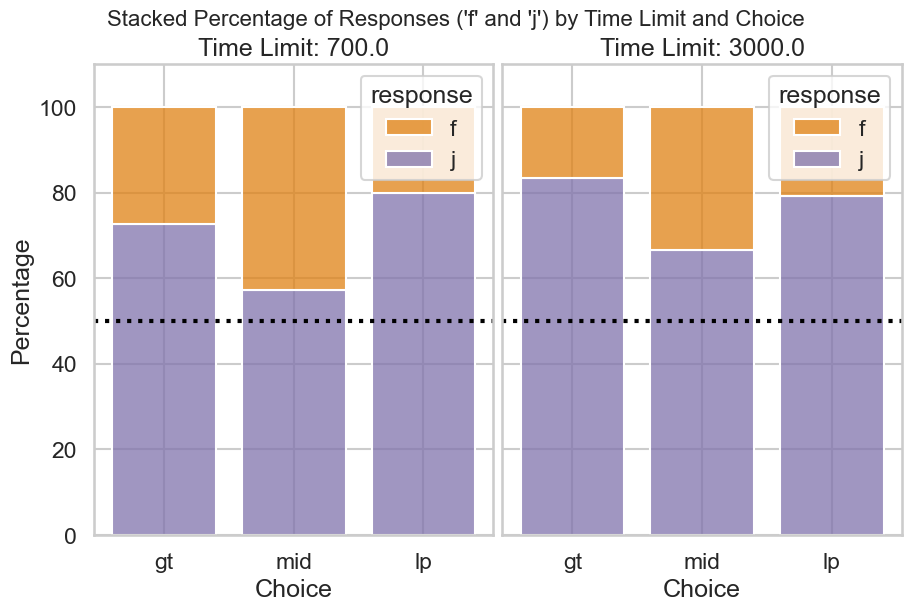

In [53]:
# Example usage:
directory = 'rawData_v2/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
file = files[3]
# file = 'rawData_v1/67983c5d4a34e_result.csv'
df = process_file(file)
print('----------Data Quality Check---------')
summary = analyze_data(df)
print('---------CLEAR---------')
cm = get_confusionMatrix(df)
cm_metric = calculate_metrics(cm)
pprint(cm_metric)
plot_stacked_freq(df)

## All Participants Data

In [ ]:
# Process each file
directory = 'rawData_v2/'
files = [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.csv')]
print(len(files))
dfs = []
for i, file in enumerate(files):   
    df = process_file(file)
    print('----------Data Quality Check---------')
    summary = analyze_data(df)
    print('---------CLEAR---------')
    cm = get_confusionMatrix(df)
    cm_metric = calculate_metrics(cm)
    pprint(cm_metric)
    plot_stacked_freq(df)
    # if file != 'rawData_v0/67884b1aa6c55d9dd2388778_result.csv': # rawData_v0 participant data excluded
    #     dfs.append(df)
    #     print('Attaching new participant data...')
    # if file != 'rawData_v1/66632c69d2b270f0314a0b16_result.csv': # rawData_v1 participant data excluded
    #     dfs.append(df)
    #     print(f'Attaching participant {i} data...')
    if file != 'rawData_v2/6728092788e31f69b592fda0_result.csv': # rawData_v2 participant data excluded
        dfs.append(df)
        print(f'Attaching participant {i} data...')

# Merge all dataframes
df_all = pd.concat(dfs, ignore_index=True)
df_all['choice'] = pd.Categorical(df_all['choice'], categories=choice_order, ordered=True)

## flip rate
flipRate = df_all['flipped'].mean()
print(f'Flip Rate: {flipRate}')

In [ ]:
# for debug
# df_all = pd.concat(dfs, ignore_index=True)
# print("Total rows:", len(df_all))
# print("Unique subject IDs:", df_all['subject_id'].nunique())
# print("List of unique subject IDs:", df_all['subject_id'].unique())

T-Test Results:
T-Statistic: -46.039, P-Value: 1.649e-290
Result: The difference in RTs between time limits is statistically significant.

Analysis Summary:
{'Missing Rate': {'Overall': 0.08698830409356725,
                  'By TimeLimit': {700.0: 0.16447368421052633, 3000.0: 0.009502923976608187},
                  'By Choice': {'gt': 0.07894736842105263,
                                'mid': 0.08991228070175439,
                                'lp': 0.09210526315789473}},
 'RT': {'Overall': 849.6369095276222,
        'By TimeLimit': {700.0: 499.1968503937008, 3000.0: 1145.2479704797047},
        'By Choice': {'gt': 833.8404761904762, 'mid': 845.8855421686746, 'lp': 869.4227053140097}},
 'Accuracy': {'Overall': 0.5500400320256205,
              'By TimeLimit': {700.0: 0.5249343832020997, 3000.0: 0.5712177121771218},
              'By Choice': {'gt': 0.6845238095238095,
                            'mid': 0.41686746987951806,
                            'lp': 0.5471014492753623}},
 'A

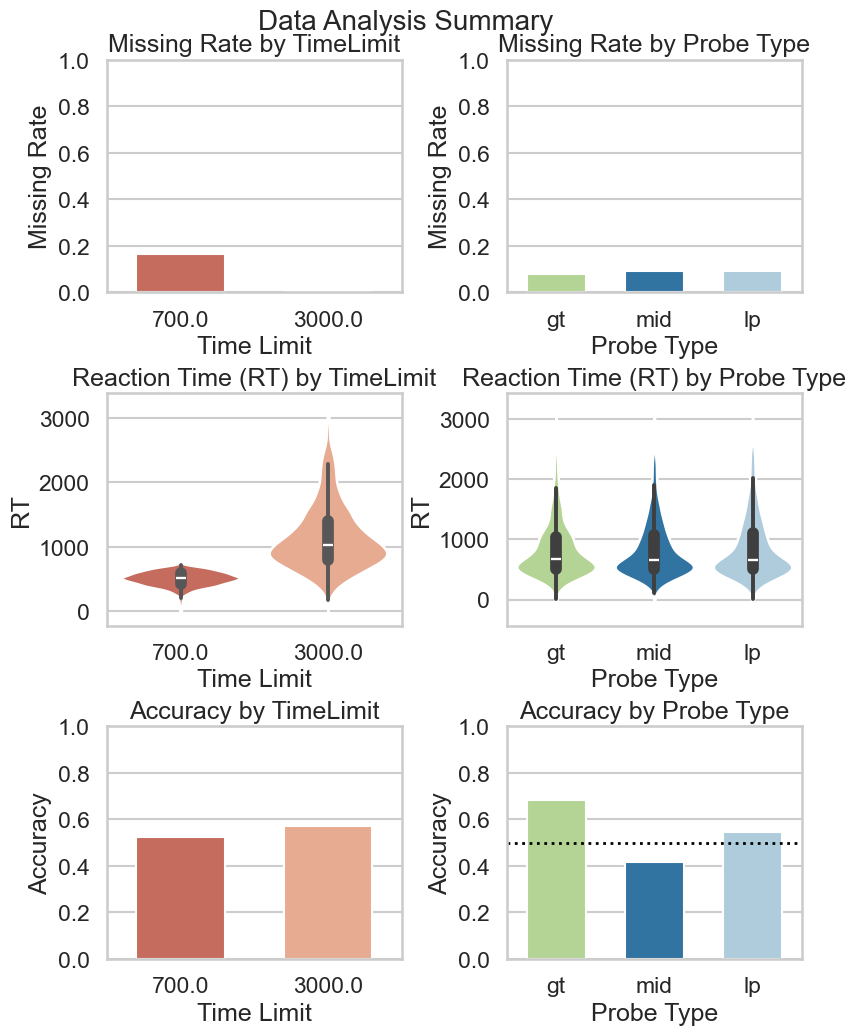

---------CLEAR---------


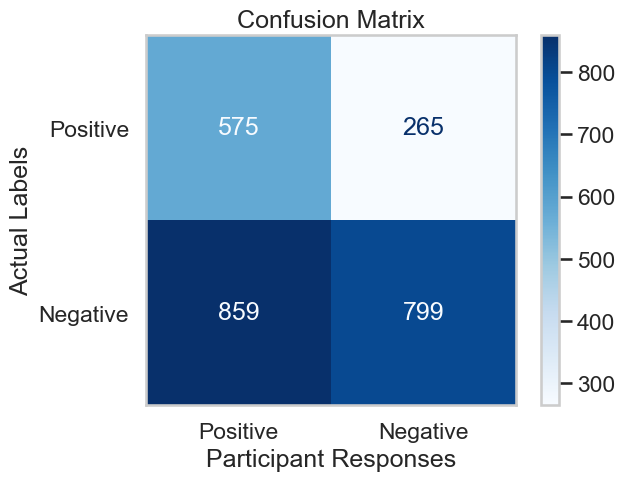

Confusion Matrix for timeLimit = 3000.0
[[330 123]
 [458 444]]
Confusion Matrix for timeLimit = 700.0
[[245 142]
 [401 355]]
Confusion Matrix for timeLimit = mid
[[  0   0]
 [484 346]]
Confusion Matrix for timeLimit = gt
[[575 265]
 [  0   0]]
Confusion Matrix for timeLimit = lp
[[  0   0]
 [375 453]]
{'Accuracy': 0.5500400320256205,
 'F1 Score': 0.5870683321087435,
 'False Negatives': 859,
 'False Positives': 265,
 'Precision': 0.7509398496240601,
 'Recall': 0.4819059107358263,
 'True Negatives': 575,
 'True Positives': 799}


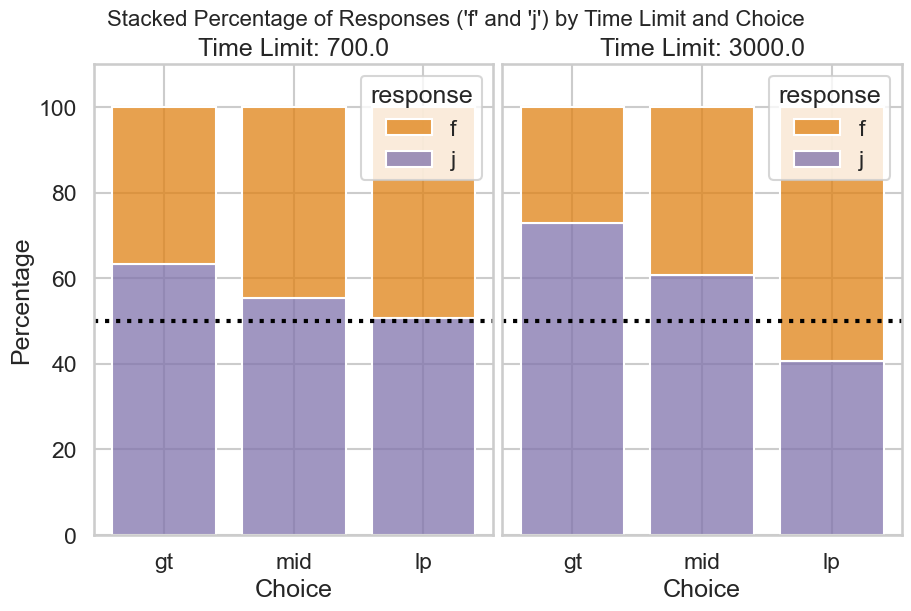

In [10]:
# df_all.to_csv('df_all_pilot_v2_19participants.csv', index=False)
df_all = pd.read_csv('df_all_pilot_v2_19participants.csv')
df_all['is_accurate'] = df_all['is_accurate'].astype('boolean')
df_all['choice'] = pd.Categorical(df_all['choice'], categories=choice_order, ordered=True)
summary_all = analyze_data(df_all)
print('---------CLEAR---------')
cm_all = get_confusionMatrix(df_all)
cm_metric_all = calculate_metrics(cm_all)
pprint(cm_metric_all)
# drops na after calculating missing rates
df_all = df_all.dropna(subset=['response'])
plot_stacked_freq(df_all)

   choice  timeLimit response  count
0      gt      700.0        f    142
1      gt      700.0        j    245
2      gt     3000.0        f    123
3      gt     3000.0        j    330
4     mid      700.0        f    168
5     mid      700.0        j    209
6     mid     3000.0        f    178
7     mid     3000.0        j    275
8      lp      700.0        f    187
9      lp      700.0        j    192
10     lp     3000.0        f    266
11     lp     3000.0        j    183
   choice  timeLimit response  count  total  percentage
0      gt      700.0        f    142    387   36.692506
1      gt      700.0        j    245    387   63.307494
2      gt     3000.0        f    123    453   27.152318
3      gt     3000.0        j    330    453   72.847682
4     mid      700.0        f    168    377   44.562334
5     mid      700.0        j    209    377   55.437666
6     mid     3000.0        f    178    453   39.293598
7     mid     3000.0        j    275    453   60.706402
8      lp      

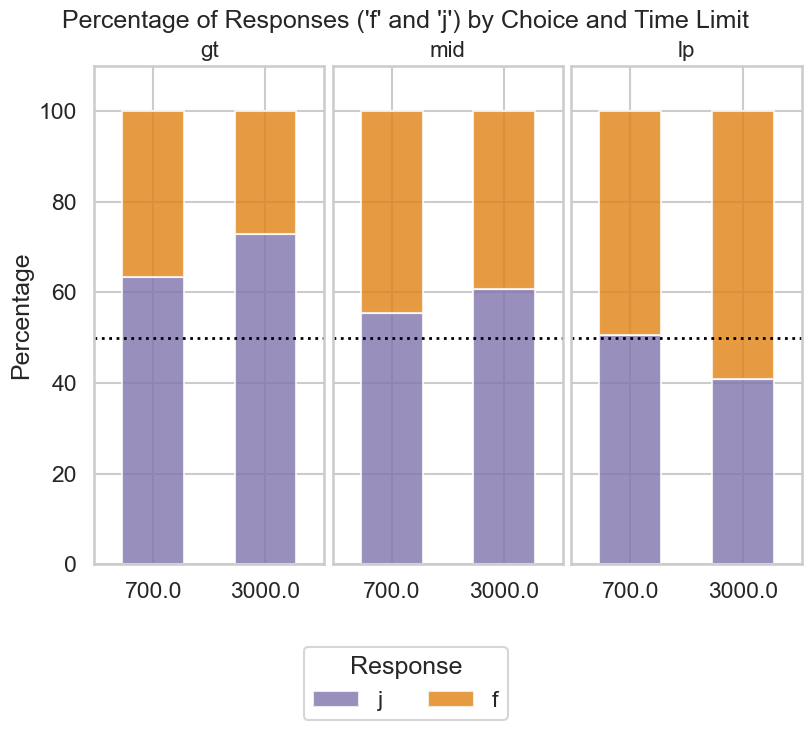

In [11]:
# Create stacked bar plot with grouped x-axis
def plot_grouped_stacked_bar(data):
    sns.set_theme(style="whitegrid", context="talk")  # Use a clean theme

    # Drop missing responses
    data = data.dropna(subset=['response'])

    # Prepare data for grouped stacked bar plot
    grouped_data = (
        data.groupby(['choice', 'timeLimit', 'response'])
        .size()
        .reset_index(name='count')  # Count occurrences
    )
    print(grouped_data)

    # Calculate percentages
    grouped_data['total'] = grouped_data.groupby(['choice', 'timeLimit'])['count'].transform('sum')
    grouped_data['percentage'] = 100 * grouped_data['count'] / grouped_data['total']

    print(grouped_data)

    # Create subplots for each choice
    choices = sorted(data['choice'].unique())
    fig, axs = plt.subplots(1, len(choices), figsize=(8, 6), sharey=True, constrained_layout=True)

    for i, choice in enumerate(choice_order):
        ax = axs[i] if len(choices) > 1 else axs  # Handle single subplot case
        subset = grouped_data[grouped_data['choice'] == choice]

        # Pivot the data for stacking
        pivot_data = subset.pivot(index='timeLimit', columns='response', values='percentage').fillna(0)

        # Reorder columns to ensure `j` is at the bottom
        pivot_data = pivot_data[['j', 'f']]  # Ensure `j` comes before `f`

        # Plot stacked bars
        pivot_data.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[response_palette['j'], response_palette['f']],
            legend=False,
            alpha=0.8,
            width=0.55
        )
        ax.set_title(f"{choice}", fontsize=16)
        ax.set_xlabel("")
        ax.set_ylabel("Percentage" if i == 0 else "", fontsize=18)
        ax.set_ylim(0, 110)  # Set y-axis to 0-100 for percentages
        ax.axhline(y=50, linewidth=2, color="black", ls=":")

        # Rotate x-axis labels to horizontal
        ax.tick_params(axis='x', labelrotation=0)

    # Add a global title
    plt.suptitle("Percentage of Responses ('f' and 'j') by Choice and Time Limit", fontsize=18)
    # Add legend for the last subplot
    handles, labels = axs[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title="Response", loc="upper center", bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.show()

# Use the updated function
plot_grouped_stacked_bar(df_all)
# plot_grouped_stacked_bar(df)

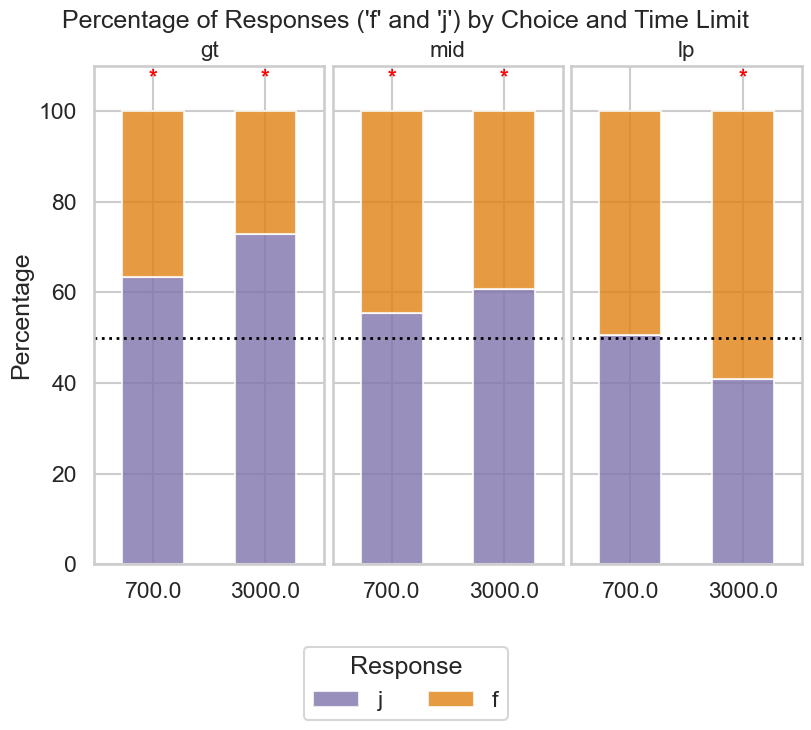

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# For the binomial test:
try:
    from scipy.stats import binomtest  # SciPy >= 1.7
except ImportError:
    from scipy.stats import binom_test
    def binomtest(k, n, p=0.5):
        return type("BinomTestResult", (), {"pvalue": binom_test(k, n, p)})()

def plot_grouped_stacked_bar(data, alpha=0.05):
    sns.set_theme(style="whitegrid", context="talk")  # Use a clean theme

    # Drop missing responses
    data = data.dropna(subset=['response'])
    data['choice'] = pd.Categorical(data['choice'], categories=choice_order, ordered=True)
    
    # Prepare data for grouped stacked bar plot
    grouped_data = (
        data.groupby(['choice', 'timeLimit', 'response'])
        .size()
        .reset_index(name='count')  # Count occurrences
    )

    # Calculate percentages
    grouped_data['total'] = grouped_data.groupby(['choice', 'timeLimit'])['count'].transform('sum')
    grouped_data['percentage'] = 100 * grouped_data['count'] / grouped_data['total']

    # Create subplots for each choice
    choices = sorted(data['choice'].unique())
    fig, axs = plt.subplots(1, len(choices), figsize=(8, 6), sharey=True, constrained_layout=True)

    for i, choice in enumerate(choice_order):
        # If there's only one choice, axs is not an array
        ax = axs[i] if len(choices) > 1 else axs

        subset = grouped_data[grouped_data['choice'] == choice]

        # Pivot the data for stacking (percentages)
        pivot_data = subset.pivot(index='timeLimit', columns='response', values='percentage').fillna(0)
        # Reorder columns to ensure `j` is at the bottom
        pivot_data = pivot_data[['j', 'f']]

        # --- Get the count data for binomial test ---
        pivot_counts = subset.pivot(index='timeLimit', columns='response', values='count').fillna(0)
        # Ensure same column order ['j','f']
        for col in ['j', 'f']:
            if col not in pivot_counts.columns:
                pivot_counts[col] = 0
        pivot_counts = pivot_counts[['j','f']]

        # Plot stacked bars (original code)
        pivot_data.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[response_palette['j'], response_palette['f']],  # if you have a predefined palette
            legend=False,
            alpha=0.8,
            width=0.55
        )
        ax.set_title(f"{choice}", fontsize=16)
        ax.set_xlabel("")
        ax.set_ylabel("Percentage" if i == 0 else "", fontsize=18)
        ax.set_ylim(0, 110)  # Set y-axis to 0-100 for percentages
        ax.axhline(y=50, linewidth=2, color="black", ls=":")

        # Rotate x-axis labels to horizontal
        ax.tick_params(axis='x', labelrotation=0)

        # -------------------------------------------------
        # Perform binomial tests and add stars when p < alpha
        # -------------------------------------------------
        # We'll test if the proportion of 'j' differs from 0.5 in each timeLimit
        # for this particular choice.
        for bar_index, time_lim in enumerate(pivot_data.index):
            n_j = pivot_counts.loc[time_lim, 'j']
            n_f = pivot_counts.loc[time_lim, 'f']
            n_total = n_j + n_f

            if n_total > 0:
                result = binomtest(n_j, n_total, p=0.5)
                if result.pvalue < alpha:
                    # We place a star above the stacked bar
                    # Get the top of the bar (j% + f%)
                    y_j = pivot_data.loc[time_lim, 'j']   # stacked height of 'j'
                    y_f = pivot_data.loc[time_lim, 'f']   # stacked height of 'f'
                    top_height = y_j + y_f

                    ax.text(
                        bar_index,             # x-position at the bar index
                        top_height + 5,        # y-position slightly above
                        "*",
                        ha='center',
                        va='bottom',
                        fontsize=16,
                        color='red',
                        fontweight='bold'
                    )

    # Add a global title
    plt.suptitle("Percentage of Responses ('f' and 'j') by Choice and Time Limit", fontsize=18)

    # Add legend for the last subplot
    if len(choices) > 1:
        handles, labels = axs[-1].get_legend_handles_labels()
    else:
        handles, labels = axs.get_legend_handles_labels()

    fig.legend(handles, labels, title="Response", loc="upper center",
               bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.show()

# Usage:
plot_grouped_stacked_bar(df_all)

In [64]:
import numpy as np
from scipy.stats import wilcoxon

# Calculate proportion of 'j' responses by participant, timeLimit, and choice
response_j_by_participant = (
    df_all.assign(is_j=df_all['response'] == 'j')  # Create a boolean column for 'j' responses
    .groupby(['subject_id', 'timeLimit', 'choice'])['is_j']
    .mean()
    .reset_index()
)
results = {}

for ch in choice_order:  # e.g. ['A','B','C'] if you have 3 choices
    # Subset for the given choice
    df_choice = response_j_by_participant[response_j_by_participant['choice'] == ch]

    # Pivot to get wide format: index = subject_id, columns = timeLimit, values = proportion
    df_wide = df_choice.pivot(index='subject_id', columns='timeLimit', values='is_j')
    
    # Drop any participants missing data in either time limit
    df_wide = df_wide.dropna(subset=[700.0, 3000.0])
    print(df_wide)
    if not df_wide.empty:
        # Wilcoxon signed-rank test
        stat, p_value = wilcoxon(df_wide[700.0], df_wide[3000.0], alternative='two-sided')
        print(stat, p_value)
        results[ch] = p_value
    else:
        results[ch] = np.nan

print("Paired Wilcoxon results by choice:")
for ch, pval in results.items():
    print(f"Choice {ch}: p-value = {pval}")

timeLimit                   700.0     3000.0
subject_id                                  
58a0c507890ea500014c4e9b  0.526316  0.416667
5a78dbb9ae9a0b0001a97212  0.476190  0.833333
5bad8fc39c0cc900017a6a28  0.708333  0.916667
5d337586669d96001cbbb059  0.695652  0.791667
5de7d12c26dd95000b6824c5  0.450000  0.583333
5eaee5a2b1ad425c2eb0061d  0.600000  0.791667
5fd95f2691ac2024f8a883dd  0.521739  0.666667
605a2dbead400eae8de18f8c  0.833333  0.875000
62a36469aa54a53fcfcc27d2  0.785714  0.625000
6400e3697879c55c323f34d0  0.590909  0.958333
652ebf9490189b8b57f1ce35  0.625000  0.750000
65e254b55a2803a51872aef0  0.500000  0.666667
663a77b9f973602bcedaf526  0.727273  0.833333
66413abd57f96e210a9cfe13  0.647059  0.708333
671c6fad5a9935e94b3025fd  0.750000  0.791667
673f6c92a931906b3b255300  0.473684  0.500000
6759fa50a9bb240e423de357  0.812500  0.636364
6762abbea62dc4c2acf59fe0  0.833333  0.826087
676ac49d62a07c31a31e85ec  0.608696  0.666667
38.0 0.020412445068359375
timeLimit                   7

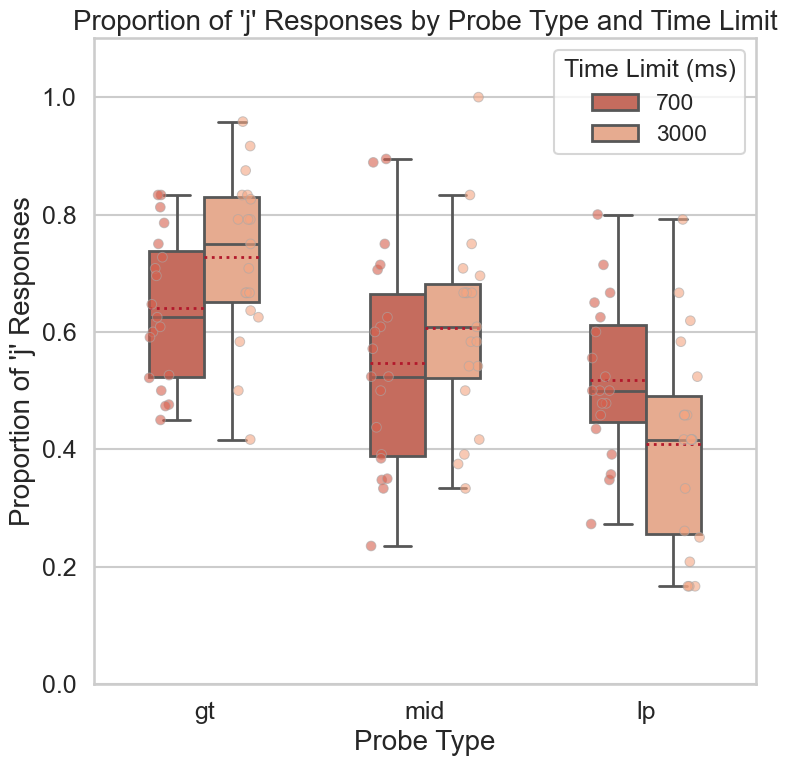

In [12]:
# Refined Plot: Proportion of 'j' Responses with Scatter Overlay
def plot_response_distribution_refined(data):
    sns.set_theme(style="whitegrid", context="talk")  # Use a clean theme

    # Calculate proportion of 'j' responses by participant, timeLimit, and choice
    response_j_by_participant = (
        data.assign(is_j=data['response'] == 'j')  # Create a boolean column for 'j' responses
        .groupby(['subject_id', 'timeLimit', 'choice'])['is_j']
        .mean()
        .reset_index()
    )

    # Create the figure
    plt.figure(figsize=(8, 8), constrained_layout=True)

    # Box plot for proportions with narrower boxes
    box = sns.boxplot(
        data=response_j_by_participant,
        x='choice',
        y='is_j',
        hue='timeLimit',
        palette={700.0: "#d6604d", 3000.0: "#f4a582"},
        order=choice_order,
        dodge=True,
        width=0.5,  # Narrower boxes
        showmeans=True,  # Add mean line
        meanline=True,  # Use a line for the mean
        meanprops={"color": "#b2182b", "ls": ":", "lw": 2},  # Style for mean line
        linewidth=2,  # Outline points
        fliersize=0  # Hide default outliers
    )

    # Add scatter points for individual data points
    scatter = sns.stripplot(
        data=response_j_by_participant,
        x='choice',
        y='is_j',
        hue='timeLimit',
        palette={700.0: "#d6604d", 3000.0: "#f4a582"},
        order=choice_order,
        dodge=True,
        alpha=0.6,  # Transparency for overlapping points
        size=7,  # Adjust point size
        linewidth=0.7,  # Outline points
        edgecolor="darkgray"
    )

    # Refine the legend to avoid duplication
    handles, labels = box.get_legend_handles_labels()
    plt.legend(handles[:2], ['700', '3000'], title="Time Limit (ms)")

    # Customize title and labels
    plt.title("Proportion of 'j' Responses by Probe Type and Time Limit", fontsize=20)
    plt.xlabel("Probe Type", fontsize=20)
    plt.ylabel("Proportion of 'j' Responses", fontsize=20)
    plt.xticks(fontsize=18)
    plt.yticks(fontsize=18)
    plt.ylim(0, 1.1)

    # Tight layout for better appearance
    plt.tight_layout()
    plt.show()

# Use the refined function
plot_response_distribution_refined(df_all)

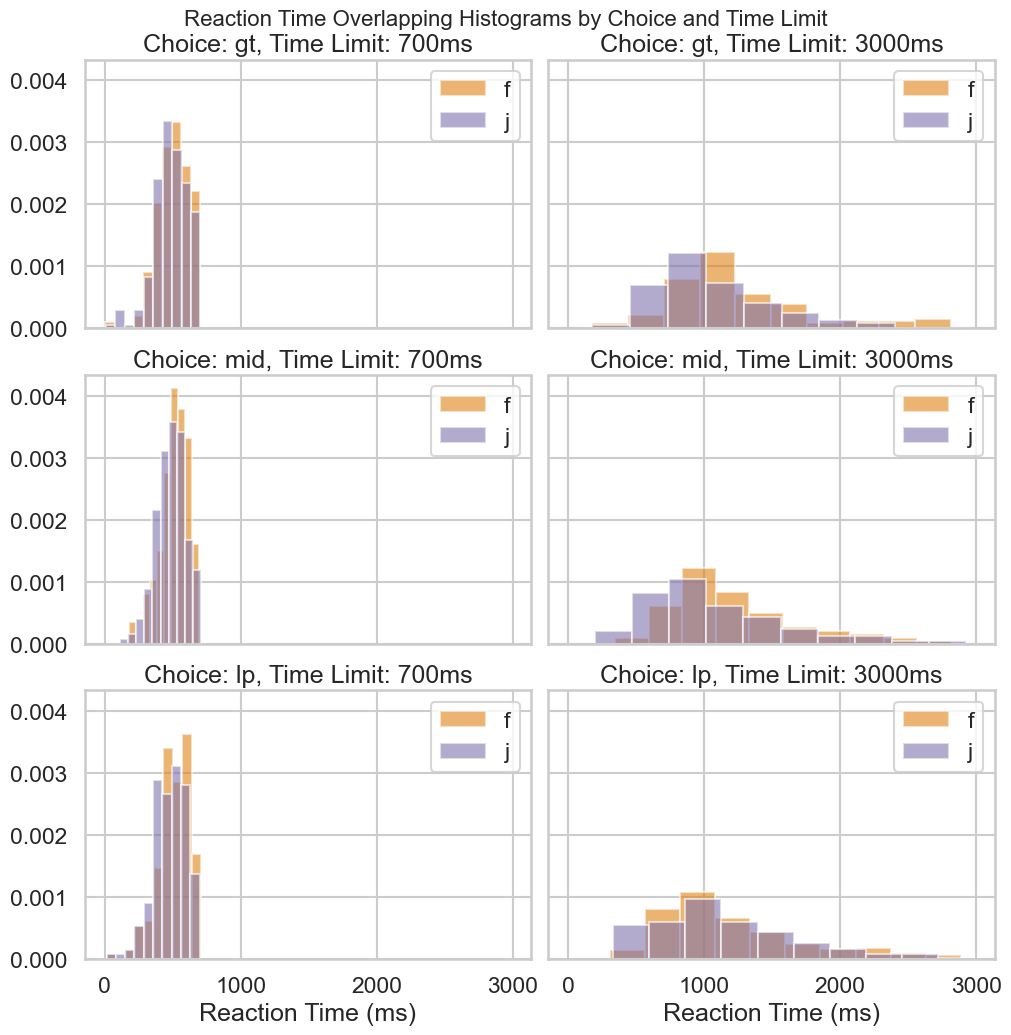

In [65]:
# Refined overlapping distribution plot using histograms
def plot_rt_histogram_grid(data):
    sns.set_theme(style="whitegrid", context="talk")

    # Create a 2x3 grid of subplots with shared x and y axes
    choices = ['gt', 'mid', 'lp']
    time_limits = [700, 3000]
    fig, axs = plt.subplots(3, 2, figsize=(10, 10), constrained_layout=True, sharex=True, sharey=True)
    
    # Iterate through choices and time limits to populate the grid
    for i, choice in enumerate(choices):
        for j, time_limit in enumerate(time_limits):
            ax = axs[i, j]
            subset = data[(data['choice'] == choice) & (data['timeLimit'] == time_limit)]
            
            # Plot overlapping histograms for responses 'f' and 'j'
            if not subset.empty:
                subset_f = subset[subset['response'] == 'f']
                subset_j = subset[subset['response'] == 'j']
                ax.hist(
                    subset_f['rt'], bins=10, alpha=0.6, color=response_palette['f'], label='f', density=True
                )
                ax.hist(
                    subset_j['rt'], bins=10, alpha=0.6, color=response_palette['j'], label='j', density=True
                )
            ax.set_title(f"Choice: {choice}, Time Limit: {time_limit}ms")
            ax.set_xlabel("Reaction Time (ms)" if i == 2 else "")
            # ax.set_ylabel("Density" if j == 0 else "")
            ax.legend(loc='upper right')

    # Add a global title
    fig.suptitle("Reaction Time Overlapping Histograms by Choice and Time Limit", fontsize=16, y=1.02)
    plt.show()

plot_rt_histogram_grid(df_all)

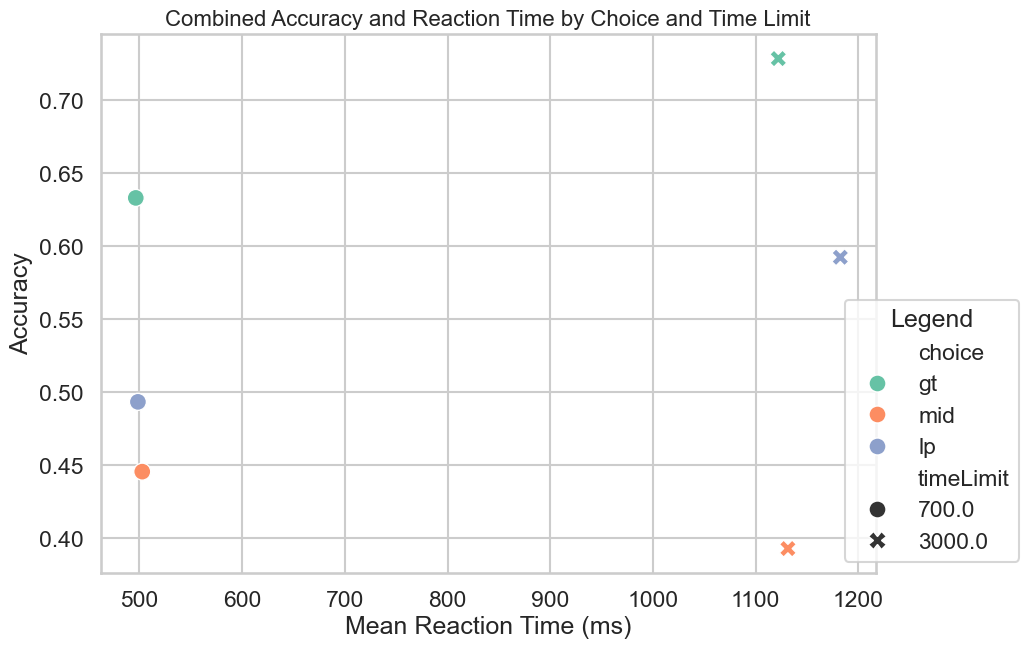

In [66]:
# Step 5: Combined Accuracy and Reaction Time Plot
def plot_combined_accuracy_rt(data):
    sns.set_theme(style="whitegrid", context="talk")

    # Calculate mean accuracy and reaction time grouped by choice and time limit
    summary = data.groupby(['choice', 'timeLimit']).agg(
        accuracy=('is_accurate', 'mean'),
        mean_rt=('rt', 'mean')
    ).reset_index()

    # Plot accuracy vs reaction time with scatter plot
    plt.figure(figsize=(10, 7))
    scatter = sns.scatterplot(
        data=summary,
        x='mean_rt',
        y='accuracy',
        hue='choice',
        style='timeLimit',
        s=150,
        palette="Set2"
    )
    scatter.set_title("Combined Accuracy and Reaction Time by Choice and Time Limit", fontsize=16)
    scatter.set_xlabel("Mean Reaction Time (ms)")
    scatter.set_ylabel("Accuracy")
    scatter.legend(title="Legend", loc='lower right', bbox_to_anchor=(1.2, 0))
    plt.show()

plot_combined_accuracy_rt(df_all)

In [ ]:
import bambi as bmb
import arviz as az

# Prepare the dataset
data = pd.read_csv('./df_all_pilot_v0_5participants.csv')
data = data.dropna(subset=['rt', 'response', 'choice', 'timeLimit'])

# Reverse encode response: 'j' -> 0, 'f' -> 1
data['response_numeric'] = data['response'].map({'j': 1, 'f': 0})

# Ensure categorical variables are properly handled
data['choice'] = data['choice'].astype('category')
data['subject_id'] = data['subject_id'].astype('category')
data['stimulus_idx'] = data['stimulus_idx'].astype('category')

# Specify Bayesian logistic regression with mixed effects
formula = "response_numeric ~ C(choice) * C(timeLimit) + (1 + C(choice) + C(timeLimit) | subject_id) + (1 + C(choice) + C(timeLimit) | stimulus_idx)"

# Fit the Bayesian logistic regression model
model = bmb.Model(formula, data, family="bernoulli")
results = model.fit(draws=2000, chains=4)

# Summarize the model
print(az.summary(results))

# Plot posterior distributions
az.plot_posterior(results)

In [ ]:
pprint(az.summary(results)[10:20])

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(choice), C(timeLimit), C(choice):C(timeLimit), 1|subject_id_sigma, 1|subject_id_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1701 seconds.


                                         mean     sd  hdi_3%  hdi_97%  \
Intercept                               0.626  0.162   0.322    0.923   
C(choice)[lp]                          -0.745  0.131  -0.997   -0.504   
C(choice)[mid]                          0.016  0.133  -0.238    0.261   
C(timeLimit)[3000.0]                    0.237  0.132  -0.031    0.464   
C(choice):C(timeLimit)[lp, 3000.0]     -0.385  0.183  -0.716   -0.029   
C(choice):C(timeLimit)[mid, 3000.0]    -0.293  0.189  -0.647    0.051   
1|subject_id_sigma                      0.670  0.112   0.470    0.873   
1|subject_id[5980128635fbf100017d0861]  0.812  0.228   0.385    1.247   
1|subject_id[5e5dba9e3d60470d71dde9ef]  0.300  0.217  -0.114    0.715   
1|subject_id[5e648efca8c76520c918bb31] -0.143  0.215  -0.537    0.264   
1|subject_id[5f8f54c1450c2d1b5984c34f] -0.819  0.213  -1.206   -0.405   
1|subject_id[603f28793a28f30ab6932a12] -0.718  0.213  -1.102   -0.302   
1|subject_id[61bb392e40db417c1a138dcb]  1.293  0.25

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'C(choice)\nlp'}>,
        <Axes: title={'center': 'C(choice)\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)\n3000.0'}>],
       [<Axes: title={'center': 'C(choice):C(timeLimit)\nlp, 3000.0'}>,
        <Axes: title={'center': 'C(choice):C(timeLimit)\nmid, 3000.0'}>,
        <Axes: title={'center': '1|subject_id_sigma'}>,
        <Axes: title={'center': '1|subject_id\n5980128635fbf100017d0861'}>],
       [<Axes: title={'center': '1|subject_id\n5e5dba9e3d60470d71dde9ef'}>,
        <Axes: title={'center': '1|subject_id\n5e648efca8c76520c918bb31'}>,
        <Axes: title={'center': '1|subject_id\n5f8f54c1450c2d1b5984c34f'}>,
        <Axes: title={'center': '1|subject_id\n603f28793a28f30ab6932a12'}>],
       [<Axes: title={'center': '1|subject_id\n61bb392e40db417c1a138dcb'}>,
        <Axes: title={'center': '1|subject_id\n65b929230cff388d15dd5c4c'}>,
        <Axes: title={'center': '1|subject_id\n662692c1a

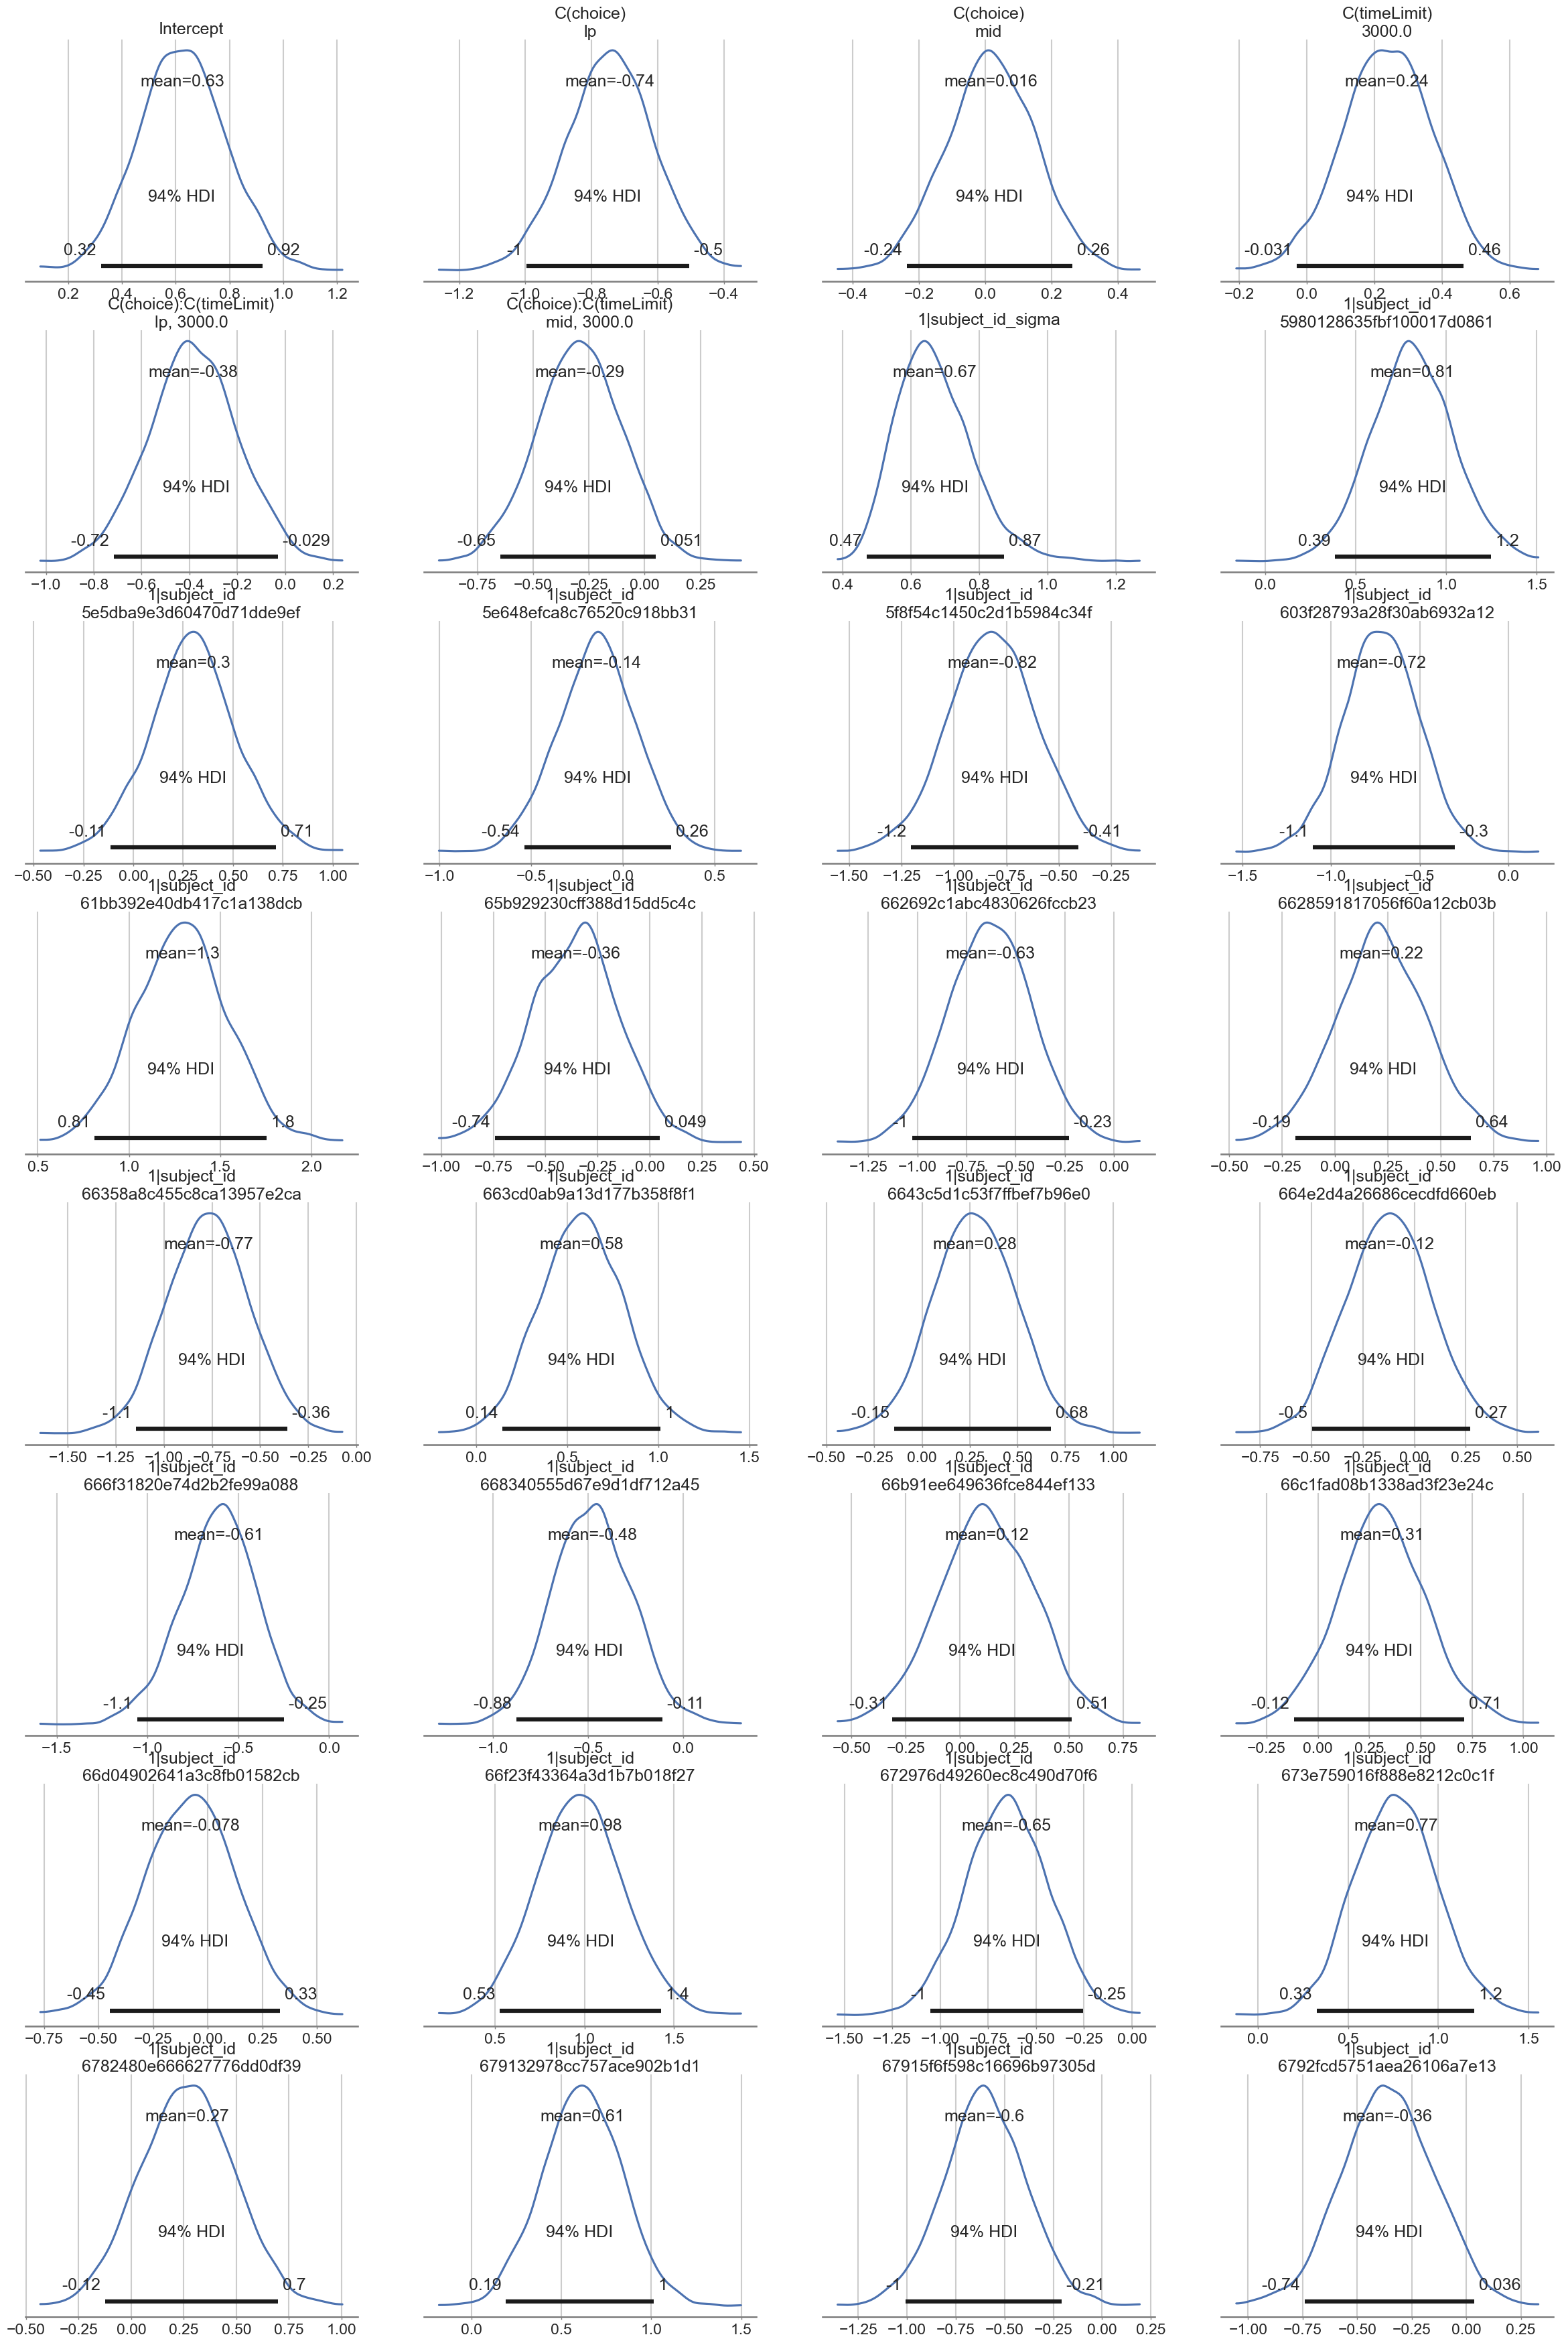

In [ ]:
## a simpler model
import bambi as bmb
import arviz as az

# Prepare the dataset
data = pd.read_csv('./df_all_pilot_v1_25participants.csv')
data = data.dropna(subset=['rt', 'response', 'choice', 'timeLimit'])

# Reverse encode response: 'j' -> 0, 'f' -> 1
data['response_numeric'] = data['response'].map({'j': 1, 'f': 0})

# Ensure categorical variables are properly handled
data['choice'] = data['choice'].astype('category')
data['subject_id'] = data['subject_id'].astype('category')
data['stimulus_idx'] = data['stimulus_idx'].astype('category')

# Specify Bayesian logistic regression with mixed effects
formula_1 = "response_numeric ~ C(choice)*C(timeLimit) + (1 | subject_id)"

# Fit the Bayesian logistic regression model
model_1 = bmb.Model(formula_1, data, family="bernoulli")
results_1 = model_1.fit(draws=1000, chains=4, cores=4)

# Summarize the model
print(az.summary(results_1))

# Plot posterior distributions
az.plot_posterior(results_1)

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Intercept, C(choice), C(timeLimit), C(choice):C(timeLimit), 1|subject_id_sigma, 1|subject_id_offset]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 8 seconds.


                                         mean     sd  hdi_3%  hdi_97%  \
Intercept                              -0.113  0.172  -0.445    0.212   
C(choice)[mid]                          0.767  0.133   0.516    1.013   
C(timeLimit)[3000.0]                   -0.145  0.126  -0.390    0.082   
C(choice):C(timeLimit)[mid, 3000.0]     0.096  0.181  -0.244    0.436   
1|subject_id_sigma                      0.716  0.124   0.501    0.957   
1|subject_id[5980128635fbf100017d0861]  0.854  0.267   0.332    1.342   
1|subject_id[5e5dba9e3d60470d71dde9ef] -0.024  0.249  -0.487    0.436   
1|subject_id[5e648efca8c76520c918bb31] -0.079  0.254  -0.567    0.371   
1|subject_id[5f8f54c1450c2d1b5984c34f] -0.580  0.250  -1.052   -0.111   
1|subject_id[603f28793a28f30ab6932a12] -0.997  0.262  -1.497   -0.530   
1|subject_id[61bb392e40db417c1a138dcb]  1.440  0.299   0.926    2.037   
1|subject_id[65b929230cff388d15dd5c4c] -1.123  0.264  -1.613   -0.620   
1|subject_id[662692c1abc4830626fccb23] -0.789  0.25

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'C(choice)\nmid'}>,
        <Axes: title={'center': 'C(timeLimit)\n3000.0'}>],
       [<Axes: title={'center': 'C(choice):C(timeLimit)\nmid, 3000.0'}>,
        <Axes: title={'center': '1|subject_id_sigma'}>,
        <Axes: title={'center': '1|subject_id\n5980128635fbf100017d0861'}>],
       [<Axes: title={'center': '1|subject_id\n5e5dba9e3d60470d71dde9ef'}>,
        <Axes: title={'center': '1|subject_id\n5e648efca8c76520c918bb31'}>,
        <Axes: title={'center': '1|subject_id\n5f8f54c1450c2d1b5984c34f'}>],
       [<Axes: title={'center': '1|subject_id\n603f28793a28f30ab6932a12'}>,
        <Axes: title={'center': '1|subject_id\n61bb392e40db417c1a138dcb'}>,
        <Axes: title={'center': '1|subject_id\n65b929230cff388d15dd5c4c'}>],
       [<Axes: title={'center': '1|subject_id\n662692c1abc4830626fccb23'}>,
        <Axes: title={'center': '1|subject_id\n6628591817056f60a12cb03b'}>,
        <Axes: title={'cen

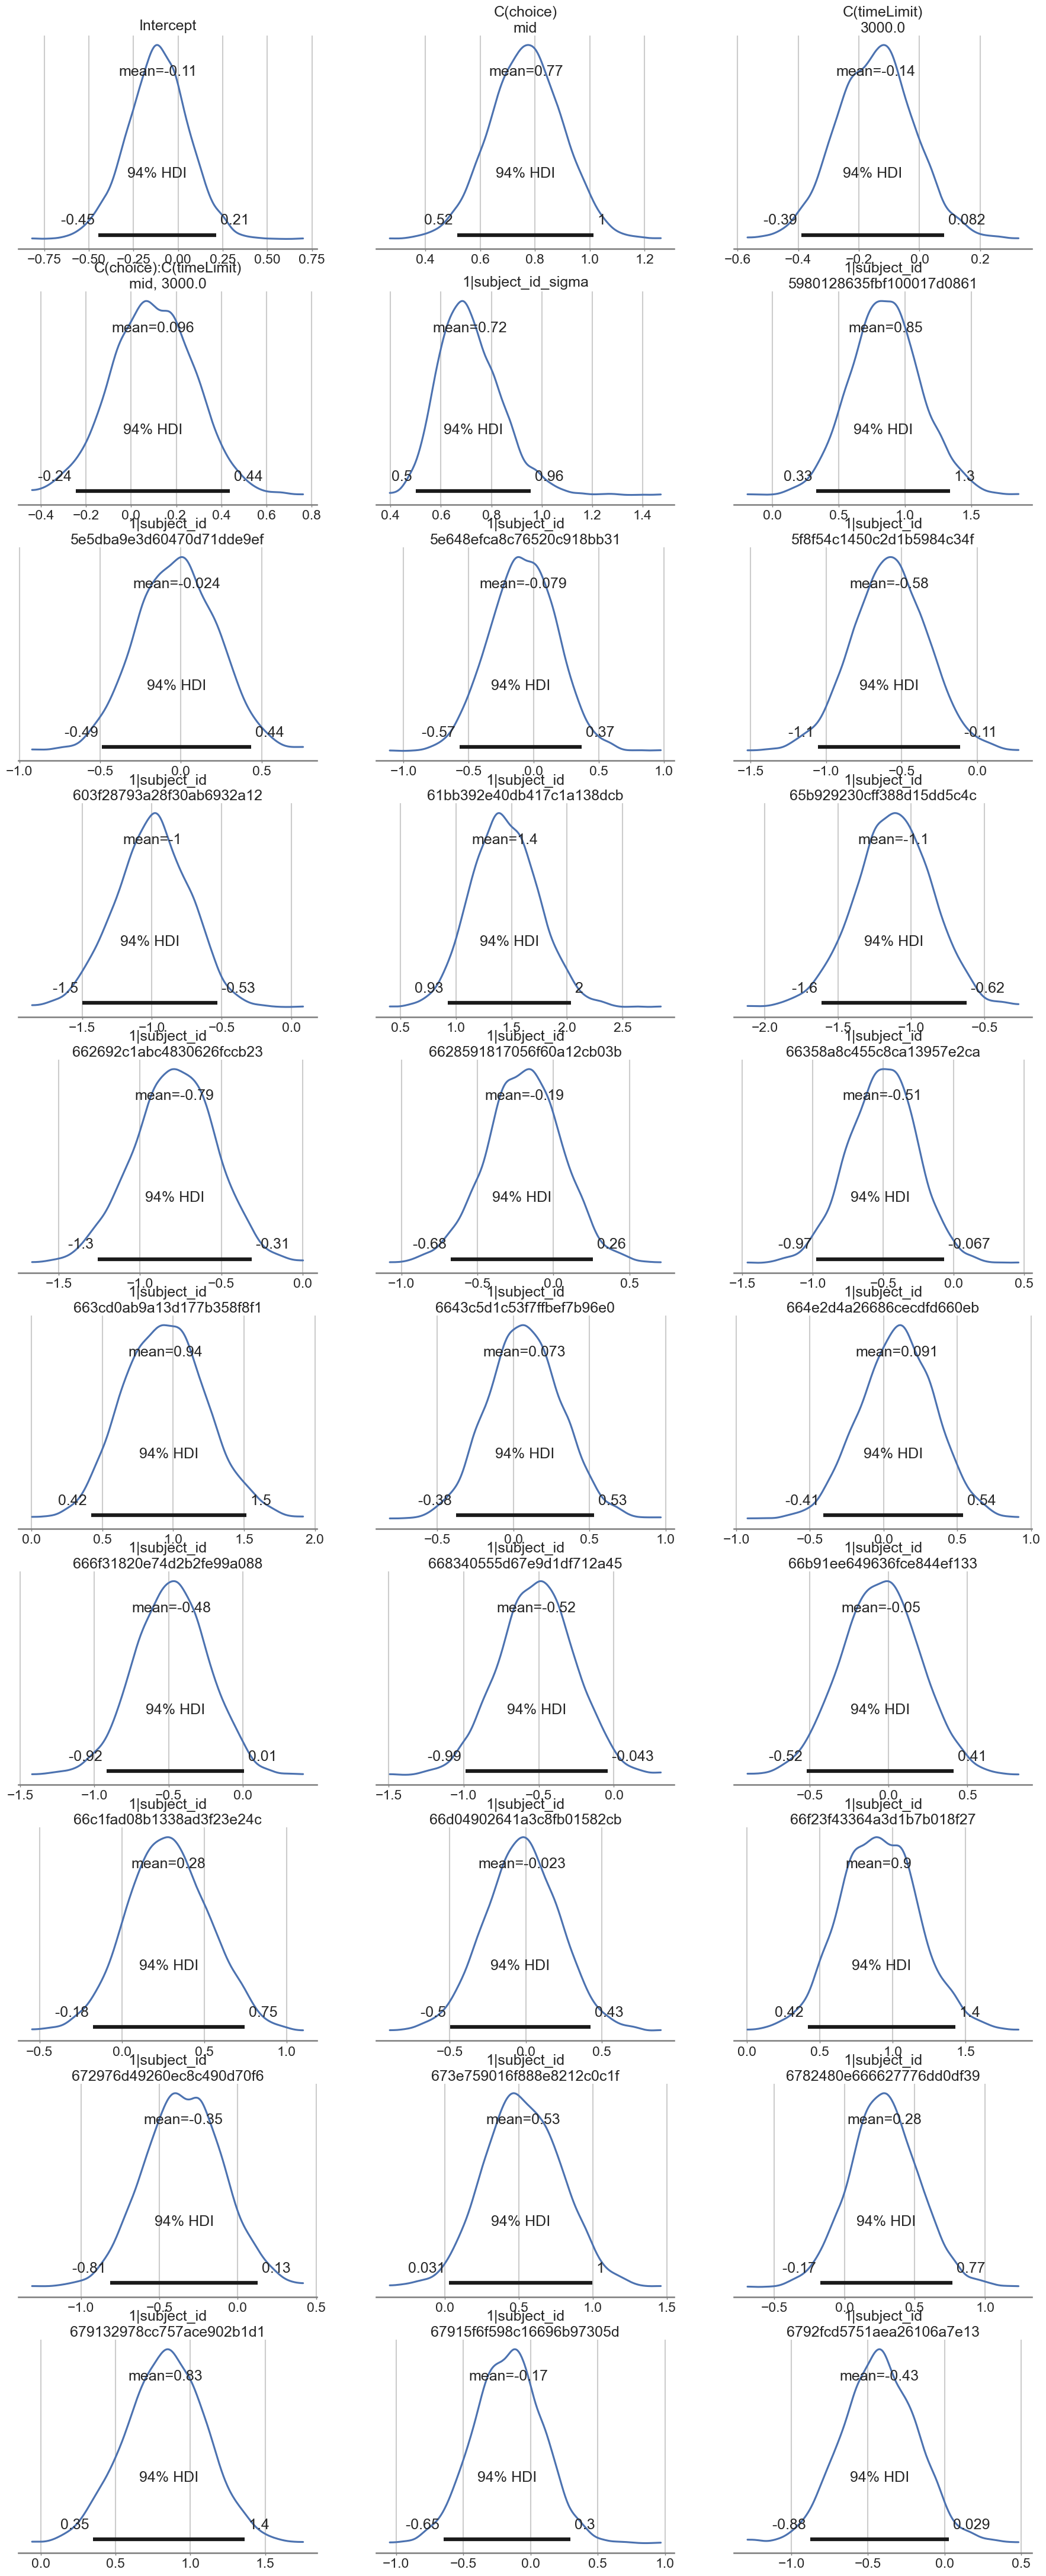

In [19]:
# only looking at mid/lp

# Read and prepare the full dataset as before
data = pd.read_csv('df_all_pilot_v1_25participants.csv')
data = data.dropna(subset=['rt', 'response', 'choice', 'timeLimit'])

# Map 'j' -> 1, 'f' -> 0
data['response_numeric'] = data['response'].map({'j': 1, 'f': 0})

# Subset to only 'mid' and 'lp'
subset_data = data[data['choice'].isin(['mid', 'lp'])].copy()

# Remove unused category levels
subset_data['subject_id'] = subset_data['subject_id'].astype('category')
subset_data['stimulus_idx'] = subset_data['stimulus_idx'].astype('category')

# Define your model on the subset
formula_2 = "response_numeric ~ C(choice)*C(timeLimit) + (1 | subject_id)"

model_2 = bmb.Model(formula_2, subset_data, family="bernoulli")
results_2 = model_2.fit(draws=1000, chains=4, cores=4)

# Summarize
print(az.summary(results_2))
az.plot_posterior(results_2)

## other code (might be useful also might not)

In [ ]:
# Updated Visualization for Predicted Probabilities
def visualize_predicted_probabilities(model, data):
    sns.set_theme(style="whitegrid", context="talk")

    # Add predicted probabilities to the dataset
    data['predicted_prob'] = model.predict()

    # Scatter plot with colors for `choice` and shapes for `timeLimit`
    plt.figure(figsize=(8, 5))
    sns.scatterplot(
        data=data,
        x='choice',
        y='predicted_prob',
        hue='choice',
        style='timeLimit',
        palette="Set2",
        s=100,
        alpha=0.8
    )
    plt.title("Predicted Probabilities by Choice and Time Limit")
    plt.xlabel("Choice")
    plt.ylabel("Predicted Probability of Response 'f'")
    plt.legend(title="Legend", loc="upper right", bbox_to_anchor=(1.3, 1))
    plt.show()

visualize_predicted_probabilities(logit_model, data)

In [ ]:
def plot_grouped_bar_rt_by_choice_time_limit(df):
    """
    Creates grouped bar plots showing RT by choice and timeLimit for accurate and inaccurate trials.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Filter data for accurate and inaccurate trials
    df['is_accurate'] = (
        ((df['response'] == 'j') & (df['choice'] == 'gt')) |
        ((df['response'] == 'f') & (df['choice'].isin(['lp', 'mid'])))
    )
    accurate_trials = df[df['is_accurate']]
    inaccurate_trials = df[~df['is_accurate']]

    # Group data by timeLimit and choice for both accurate and inaccurate trials
    rt_accurate = accurate_trials.groupby(['timeLimit', 'choice'])['rt'].mean().reset_index()
    rt_inaccurate = inaccurate_trials.groupby(['timeLimit', 'choice'])['rt'].mean().reset_index()

    # Create the plots
    fig, axs = plt.subplots(1, 2, figsize=(16, 6), sharey=True, constrained_layout=True)

    # Accurate trials plot
    sns.barplot(data=rt_accurate, x='timeLimit', y='rt', hue='choice', ax=axs[0], palette="deep")
    axs[0].set_title('Reaction Time (RT) in Accurate Trials')
    axs[0].set_xlabel('Time Limit')
    axs[0].set_ylabel('Reaction Time (RT)')
    axs[0].legend(title='Choice')

    # Inaccurate trials plot
    sns.barplot(data=rt_inaccurate, x='timeLimit', y='rt', hue='choice', ax=axs[1], palette="muted")
    axs[1].set_title('Reaction Time (RT) in Inaccurate Trials')
    axs[1].set_xlabel('Time Limit')
    axs[1].set_ylabel('Reaction Time (RT)')
    axs[1].legend(title='Choice')

    # Show the plots
    plt.suptitle('Reaction Time by Choice and Time Limit', fontsize=20, y=1.02)
    plt.show()

# Example usage: Generate grouped bar plots for RTs in accurate and inaccurate trials
plot_grouped_bar_rt_by_choice_time_limit(processed_data)

In [ ]:
def plot_grouped_bar_accuracy_by_choice_timelimit(df):
    """
    Creates grouped bar plots showing accuracy by choice and timeLimit.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Group data by timeLimit and choice, calculating accuracy
    accuracy_grouped = df.groupby(['timeLimit', 'choice'])['is_accurate'].mean().reset_index()
    print(accuracy_grouped)
    # Plot accuracy grouped by timeLimit and choice
    plt.figure(figsize=(12, 6))
    sns.barplot(data=accuracy_grouped, x='timeLimit', y='is_accurate', hue='choice', palette="muted")
    plt.title('Accuracy by Choice and Time Limit')
    plt.xlabel('Time Limit')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
    plt.legend(title='Choice', loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage: Generate grouped bar plot for accuracy by choice and timeLimit
plot_grouped_bar_accuracy_by_choice_timelimit(processed_data)

In [ ]:
def plot_grouped_bar_accuracy_by_choice_timelimit(df):
    """
    Creates grouped bar plots showing accuracy by choice and timeLimit.
    """
    sns.set_theme(style="whitegrid", context="talk")  # Use a scientific theme

    # Define accuracy
    df['is_accurate'] = (
        ((df['response'] == 'j') & (df['choice'] == 'gt')) |
        ((df['response'] == 'f') & (df['choice'].isin(['lp', 'mid'])))
    )

    # Group data by timeLimit and choice, calculating accuracy
    accuracy_grouped = df.groupby(['timeLimit', 'choice'])['is_accurate'].mean().reset_index()

    # Plot accuracy grouped by timeLimit and choice
    plt.figure(figsize=(12, 6))
    sns.barplot(data=accuracy_grouped, x='timeLimit', y='is_accurate', hue='choice', palette="muted")
    plt.title('Accuracy by Choice and Time Limit')
    plt.xlabel('Time Limit')
    plt.ylabel('Accuracy')
    plt.ylim(0, 1)  # Accuracy ranges from 0 to 1
    plt.legend(title='Choice', loc='upper right')
    plt.tight_layout()
    plt.show()

# Example usage: Generate grouped bar plot for accuracy by choice and timeLimit
plot_grouped_bar_accuracy_by_choice_timelimit(processed_data)